In [21]:
import pandas as pd

# Load the data from the provided CSV file
file_path = '/home/aster/short_term_proj/data/carbonmonitor-cities_datas_2024-09-01.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()

,city,date,sector,value,timestamp
0,Melbourne,01/01/2019,Aviation,0.000817,1546300800
1,Melbourne,02/01/2019,Aviation,0.000935,1546387200
2,Melbourne,03/01/2019,Aviation,0.001007,1546473600
3,Melbourne,04/01/2019,Aviation,0.000954,1546560000
4,Melbourne,05/01/2019,Aviation,0.000958,1546646400


/tmp/ipykernel_16018/2104026760.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data['date'] = pd.to_datetime(city_data['date'], dayfirst=True)


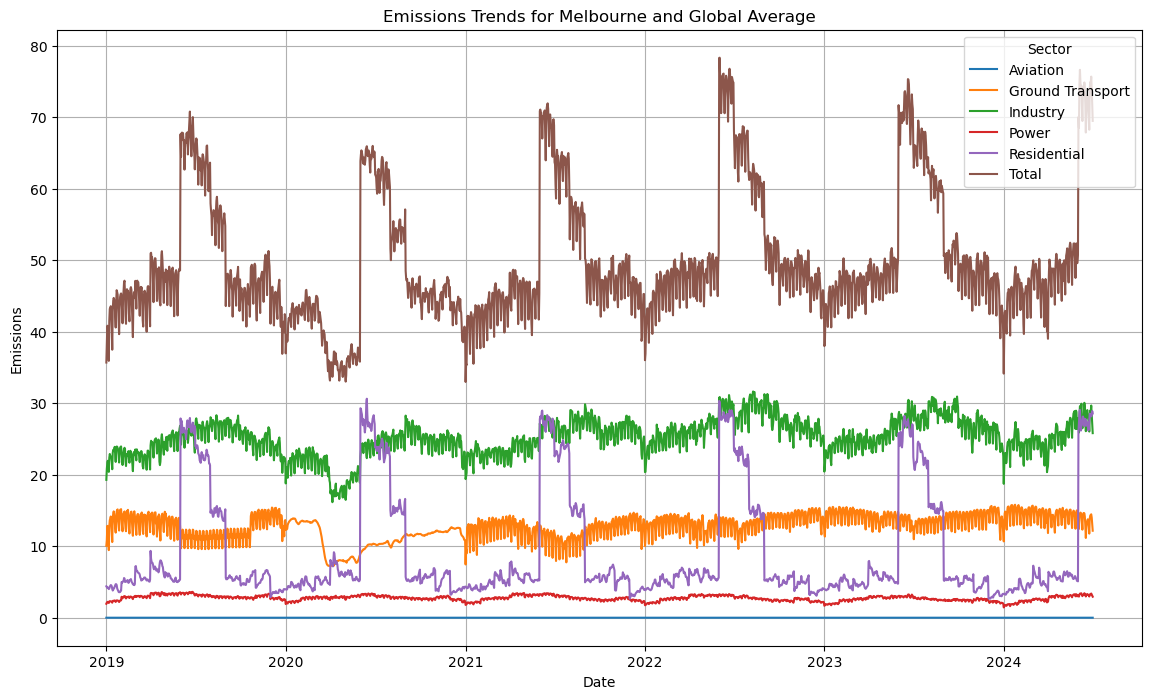

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设 data 已经定义并包含所需的数据

# 过滤墨尔本的数据
city_name = "Melbourne"
city_data = data[data['city'] == city_name]

# 将日期转换为 datetime 格式以便更好地绘图
city_data['date'] = pd.to_datetime(city_data['date'], dayfirst=True)

# 计算所有部门的总排放量
total_data = city_data.groupby('date')['value'].sum().reset_index()
total_data['sector'] = 'Total'

# 将总数据附加到城市数据中
city_data = pd.concat([city_data, total_data])

# 计算全球平均排放量
global_avg_data = data.groupby('date')['value'].mean().reset_index()
global_avg_data['sector'] = 'Global Average'

# 确保 global_avg_data 的日期也转换为 datetime 格式
global_avg_data['date'] = pd.to_datetime(global_avg_data['date'], dayfirst=True)

# 绘制每个部门的趋势
plt.figure(figsize=(14, 8))

for sector in city_data['sector'].unique():
    sector_data = city_data[city_data['sector'] == sector]
    plt.plot(sector_data['date'], sector_data['value'], label=sector)

# 绘制全球平均排放量
#plt.plot(global_avg_data['date'], global_avg_data['value'], label='Global Average', linestyle='--', color='black')

plt.title(f'Emissions Trends for {city_name} and Global Average')
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.legend(title='Sector')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np

# Filter data for Melbourne
city_name = "Melbourne"
city_data = data[data['city'] == city_name].copy()

# Convert date to datetime format
city_data['date'] = pd.to_datetime(city_data['date'], format='%d/%m/%Y')

# Aggregate data by date and sum emissions from all sectors
daily_data = city_data.groupby('date')['value'].sum().reset_index()

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
daily_data_scaled = scaler.fit_transform(daily_data[['value']])

# Create sequences for training (e.g., use past 60 days to predict the next day)
sequence_length = 60
X_train, y_train = [], []

for i in range(sequence_length, len(daily_data_scaled)):
    X_train.append(daily_data_scaled[i-sequence_length:i, 0])
    y_train.append(daily_data_scaled[i, 0])

In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=20)

# Preparing the test data for prediction (next 3 years, 1095 days)
test_input = daily_data_scaled[-sequence_length:]  # Start with the last 60 days of data
X_test = []

for i in range(1095):  # Predict for 1095 days (3 years)
    current_input = test_input[-sequence_length:].reshape(1, sequence_length, 1)
    pred_value = model.predict(current_input)
    X_test.append(pred_value[0][0])
    test_input = np.append(test_input, pred_value)[1:]  # Update the input sequence

# Inverse transform the predictions to the original scale
predicted_values = scaler.inverse_transform(np.array(X_test).reshape(-1, 1))

# Create a date range for the next 3 years
future_dates = pd.date_range(start=daily_data['date'].iloc[-1] + pd.Timedelta(days=1), periods=1095)

# Create a DataFrame with the predicted values
predicted_df = pd.DataFrame(predicted_values, index=future_dates, columns=['Predicted Emissions'])

# Plotting the predicted emissions
plt.figure(figsize=(14, 8))
plt.plot(daily_data['date'], daily_data['value'], label='Historical Emissions')
plt.plot(predicted_df.index, predicted_df['Predicted Emissions'], label='Predicted Emissions', color='red')
plt.title('Daily Carbon Emissions Prediction for Melbourne (Next 3 Years)')
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.legend()
plt.grid(True)
plt.show()


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 1/35, Loss: 0.010988778434693813
Epoch 2/35, Loss: 0.009571010246872902
Epoch 3/35, Loss: 0.0176460649818182
Epoch 4/35, Loss: 0.0075703575275838375
Epoch 5/35, Loss: 0.00791777204722166
Epoch 6/35, Loss: 0.013208294287323952
Epoch 7/35, Loss: 0.00978514738380909
Epoch 8/35, Loss: 0.009856240823864937
Epoch 9/35, Loss: 0.007827680557966232
Epoch 10/35, Loss: 0.007615469396114349
Epoch 11/35, Loss: 0.009022346697747707
Epoch 12/35, Loss: 0.011503026820719242
Epoch 13/35, Loss: 0.009268266148865223
Epoch 14/35, Loss: 0.0027367880102247
Epoch 15/35, Loss: 0.00793516542762518
Epoch 16/35, Loss: 0.005921584088355303
Epoch 17/35, Loss: 0.00495736813172698
Epoch 18/35, Loss: 0.005870415363460779
Epoch 19/35, Loss: 0.005002098623663187
Epoch 20/35, Loss: 0.00602521700784564
Epoch 21/35, Loss: 0.006681408733129501
Epoch 22/35, Loss: 0.00207332381978631
Epoch 23/35, Loss: 0.0026485181879252195
Epoch 24/35, Loss: 0.006200180854648352
Epoch 25/35, Loss: 0.0046198102645576
Epoch 26/35, Loss: 

  0%|          | 0/1095 [00:00<?, ?it/s]

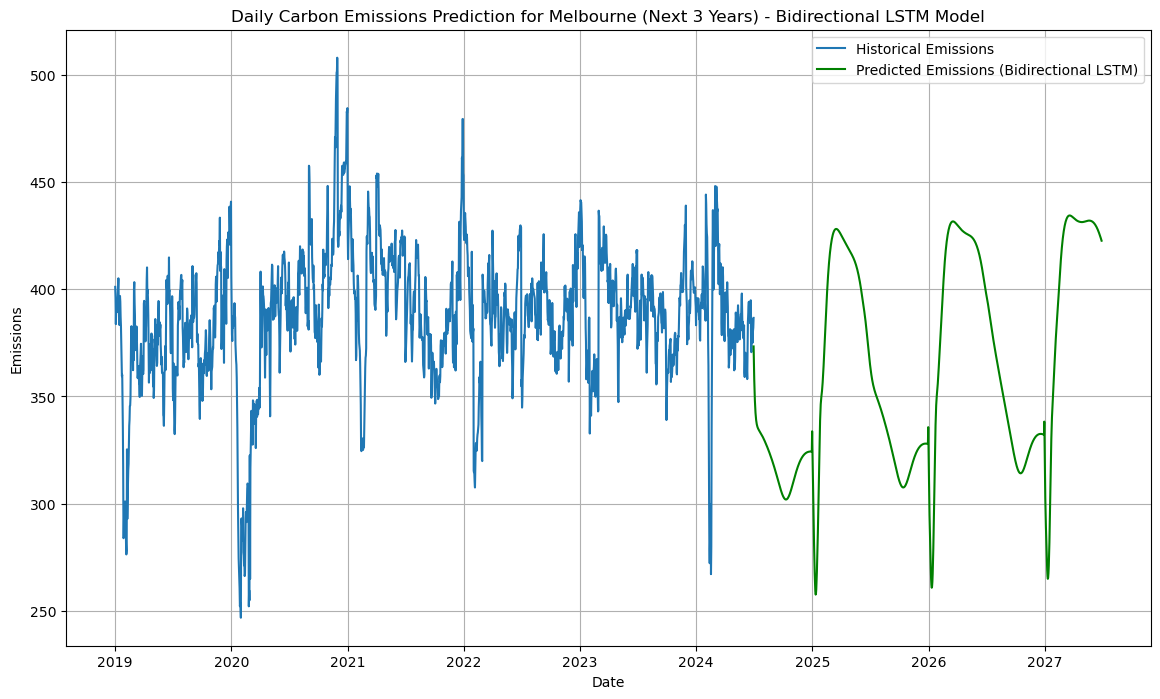

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

# 数据预处理
city_name = "Beijing"
city_data = data[data['city'] == city_name].copy()
city_data['date'] = pd.to_datetime(city_data['date'], format='%d/%m/%Y')
city_data['day_of_year'] = city_data['date'].dt.dayofyear
city_data['month'] = city_data['date'].dt.month

# 聚合数据
daily_data = city_data.groupby('date')['value'].sum().reset_index()
daily_data['day_of_year'] = daily_data['date'].dt.dayofyear
daily_data['month'] = daily_data['date'].dt.month

# 数据标准化
scaler = MinMaxScaler(feature_range=(0, 1))
daily_data_scaled = scaler.fit_transform(daily_data[['value']])

# 构建特征
features = np.concatenate([
    daily_data_scaled,
    daily_data[['day_of_year', 'month']].values
], axis=1)

# 准备训练数据
sequence_length = 100
X_train, y_train = [], []
for i in range(sequence_length, len(features)):
    X_train.append(features[i-sequence_length:i, :])
    y_train.append(features[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

# 创建DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 定义双向LSTM模型
class BidirectionalLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(BidirectionalLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # 双向LSTM的输出是hidden_size的两倍
    
    def forward(self, x):
        h_0 = torch.zeros(2 * 2, x.size(0), 50).to(x.device)  # 初始化隐藏状态 (2 * num_layers, batch_size, hidden_size)
        c_0 = torch.zeros(2 * 2, x.size(0), 50).to(x.device)  # 初始化记忆状态
        output, _ = self.lstm(x, (h_0, c_0))
        output = self.fc(output[:, -1, :])
        return output

# 模型实例化和配置
input_size = X_train.shape[2]
hidden_size = 50
output_size = 1
model = BidirectionalLSTMModel(input_size, hidden_size, output_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# 模型训练
epochs = 35
for epoch in tqdm(range(epochs)):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# 预测未来3年的数据
model.eval()
test_input = torch.tensor(features[-sequence_length:], dtype=torch.float32).unsqueeze(0).to(device)  # 保持输入为三个特征
predictions = []

# 构建初始输入特征
day_of_year_last = daily_data['day_of_year'].iloc[-sequence_length:].values
month_last = daily_data['month'].iloc[-sequence_length:].values

for _ in tqdm(range(1095)):  # 预测1095天
    with torch.no_grad():
        pred_value = model(test_input).item()
        predictions.append(pred_value)
        
        # 构建下一步的输入特征
        day_of_year_next = (day_of_year_last[-1] + 1) % 365
        if day_of_year_next == 0:
            day_of_year_next = 365
        month_next = month_last[-1] if day_of_year_next > day_of_year_last[-1] else month_last[-1] % 12 + 1
        
        # 创建新的输入特征
        next_input = torch.tensor([[pred_value, day_of_year_next, month_next]], dtype=torch.float32).to(device)
        test_input = torch.cat((test_input[:, 1:, :], next_input.unsqueeze(0)), dim=1)  # 将新的输入特征添加到序列中
        day_of_year_last = np.append(day_of_year_last[1:], day_of_year_next)
        month_last = np.append(month_last[1:], month_next)

# 将预测值逆归一化
predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# 绘图
plt.figure(figsize=(14, 8))
plt.plot(daily_data['date'], daily_data['value'], label='Historical Emissions')
plt.plot(pd.date_range(daily_data['date'].iloc[-1], periods=1095), predicted_values, label='Predicted Emissions (Bidirectional LSTM)', color='green')
plt.title('Daily Carbon Emissions Prediction for Melbourne (Next 3 Years) - Bidirectional LSTM Model')
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Input
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

# Combine external features
city_name = "Beijing"
city_data = data[data['city'] == city_name].copy()
city_data['date'] = pd.to_datetime(city_data['date'], format='%d/%m/%Y')
city_data['day_of_year'] = city_data['date'].dt.dayofyear
city_data['month'] = city_data['date'].dt.month

# Aggregate the data by day
daily_data = city_data.groupby('date')['value'].sum().reset_index()

# Add external features
daily_data['day_of_year'] = daily_data['date'].dt.dayofyear
daily_data['month'] = daily_data['date'].dt.month

# Normalize the carbon emission data
scaler = MinMaxScaler(feature_range=(0, 1))
daily_data_scaled = scaler.fit_transform(daily_data[['value']])

# Combine the normalized emissions with external features
features = np.concatenate([
    daily_data_scaled,
    daily_data[['day_of_year', 'month']].values
], axis=1)

# Prepare the data for GRU input (using sequences of 60 days)
sequence_length = 100
X_train, y_train = [], []

for i in range(sequence_length, len(features)):
    X_train.append(features[i-sequence_length:i, :])
    y_train.append(features[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Build the GRU model with external features
gru_model = Sequential()
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(units=50, return_sequences=False))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(units=25))
gru_model.add(Dense(units=1))

# Compile the model
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
gru_model.fit(X_train, y_train, batch_size=64, epochs=30)

# Prepare test data for prediction
test_input_gru = features[-sequence_length:]  # Start with the last 60 days of data
X_test_gru = []

for i in tqdm(range(1095)):  # Predict for 1095 days (3 years)
    current_input = test_input_gru[-sequence_length:].reshape(1, sequence_length, X_train.shape[2])
    pred_value_gru = gru_model.predict(current_input)
    X_test_gru.append(pred_value_gru[0][0])

    # Update the input sequence with predicted value and external features
    next_day = (test_input_gru[-1, 1:] + [1, 1]) % [365, 12]  # Increment day and month
    next_input = np.concatenate([[pred_value_gru[0][0]], next_day], axis=0)
    test_input_gru = np.vstack([test_input_gru, next_input])[1:]

# Inverse transform the predicted values to the original scale
predicted_values_gru = scaler.inverse_transform(np.array(X_test_gru).reshape(-1, 1))

# Create a DataFrame with the predicted values
future_dates = pd.date_range(start=daily_data['date'].iloc[-1] + pd.Timedelta(days=1), periods=1095)
predicted_df_gru = pd.DataFrame(predicted_values_gru, index=future_dates, columns=['Predicted Emissions'])

# Plotting the predicted emissions with GRU model
plt.figure(figsize=(14, 8))
plt.plot(daily_data['date'], daily_data['value'], label='Historical Emissions')
plt.plot(predicted_df_gru.index, predicted_df_gru['Predicted Emissions'], label='Predicted Emissions (GRU with External Features)', color='purple')
plt.title('Daily Carbon Emissions Prediction for Melbourne (Next 3 Years) - GRU Model with External Features')
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 生成非高斯分布的扩展特征（如多项式扩展）
def non_gaussian_state_augmentation(X, degree=2):
    poly = PolynomialFeatures(degree)
    X_augmented = poly.fit_transform(X)
    return X_augmented

# 使用日期数据和其他特征作为输入
city_name = "Melbourne"
city_data = data[data['city'] == city_name].copy()

# 将日期转换为时间戳，生成多项式特征
city_data['date'] = pd.to_datetime(city_data['date'], format='%d/%m/%Y')
X = city_data[['timestamp']].values

# 使用NGSA进行状态扩展
X_augmented = non_gaussian_state_augmentation(X, degree=3)

# 目标变量为碳排放量
y = city_data['value'].values

# 将数据集分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y, test_size=0.2, random_state=42)

# 构建高斯过程回归模型，使用RBF核
kernel = C(1.0, (1e-4, 1e1)) * RBF(1, (1e-2, 1e1))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# 训练模型
gpr.fit(X_train, y_train)

# 预测未来碳排放
y_pred, sigma = gpr.predict(X_test, return_std=True)

# 绘制预测结果与实际值的对比
plt.figure(figsize=(14, 8))
plt.plot(range(len(y_test)), y_test, 'r.', markersize=10, label='Observed')
plt.plot(range(len(y_pred)), y_pred, 'b-', label='Predicted')
plt.fill_between(range(len(y_pred)), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.5, color='lightblue', label='95% Confidence Interval')
plt.title('Carbon Emissions Prediction with NGSA-GPR')
plt.xlabel('Test Sample')
plt.ylabel('Emissions')
plt.legend()
plt.show()
